# Description of the data

The datasets contain data on the use of the virtual telephony service CallMeMaybe. Its clients are organizations that need to distribute large numbers of incoming calls among various operators or make outgoing calls through their operators. Operators can also make internal calls to communicate with one another. These calls go through CallMeMaybe's network.<p>
dataset `telecom_dataset_us.csv` contains the following columns:

- `user_id` — client account ID
- `date` — date the statistics were retrieved
- `direction` — call direction (`out` for outgoing, `in` for incoming)
- `internal` — whether the call was internal (between a client's operators)
- `operator_id` — operator identifier
- `is_missed_call` — whether the call was missed
- `calls_count` — number of calls
- `call_duration` — call duration (excluding waiting time)
- `total_call_duration` — call duration (including waiting time)

 

The dataset `telecom_clients_us.csv` has the following columns:

- `user_id`
- `tariff_plan` — client's current plan
- `date_start` — client's registration date
    
    
__Table of Content__<p> <a class="anchor" id="content1"></a>

* [Step 1. study general information about calls in CallMeMaybe's network](#step1)
* [Step 2. Data preprocessing](#step2)
* [Step 3. Exploratory Data Analysis (EDA)](#step3)
* [Step 4. Determine ineffective operators](#step4)
* [Step 5. Test hypotheses](#step5)
* [Step 6. Conclusions](#step6)
* [Step 7. Resources](#step7)    
* [Step 8. Visualization using Tableu](#step8)


# Step 1: study general information about calls in CallMeMaybe's network <a class="anchor" id="step1"></a>
- quick look at number of rows and type of columns
- for for existing NaN values

In [1]:
# imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import pylab
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats
import datetime
from datetime import datetime
from scipy import stats as st
import math
import math as mth
import sys
from IPython.display import display
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
import warnings
warnings.filterwarnings('ignore')


In [2]:
# local
df_clients = pd.read_csv('/content/telecom_clients_us.csv',
                         parse_dates=['date_start'],
                         dtype={'tariff_plan':'category'})

df_data = pd.read_csv('/content/telecom_dataset_us.csv',
                      parse_dates=['date'],
                      dtype={'direction':'category','operator_id':'object'})

In [3]:
df_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25


_clients_

In [4]:
df_clients.head(2)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23


In [5]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    category      
 2   date_start   732 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 12.4 KB


In [6]:
df_clients.describe(include='all')

,user_id,tariff_plan,date_start
count,732.000000,732,732
unique,NaN,3,73
top,NaN,C,2019-09-24 00:00:00
freq,NaN,395,24
first,NaN,NaN,2019-08-01 00:00:00
last,NaN,NaN,2019-10-31 00:00:00
mean,167431.927596,NaN,NaN
std,633.810383,NaN,NaN
min,166373.000000,NaN,NaN
25%,166900.750000,NaN,NaN


In [7]:
for col in df_clients.columns:
  display(df_clients[col].value_counts())
  display('number of Nan {}'.format(df_clients[col].isna().sum()))
  print()

166926    1
168227    1
166377    1
168284    1
168281    1
         ..
167580    1
166555    1
167981    1
168601    1
167936    1
Name: user_id, Length: 732, dtype: int64

'number of Nan 0'

C    395
B    261
A     76
Name: tariff_plan, dtype: int64

'number of Nan 0'

2019-09-24    24
2019-10-09    20
2019-10-07    19
2019-08-29    18
2019-09-18    18
              ..
2019-10-26     1
2019-09-21     1
2019-09-01     1
2019-10-20     1
2019-10-19     1
Name: date_start, Length: 73, dtype: int64

'number of Nan 0'

- total of 3 groups within tariffs plan
- every user appear only one time which means all the clients are unqie with no dupps to be considered
- dates are from Aug 1st till end of October

_dataset_

In [8]:
df_data.tail(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190
53901,168606,2019-11-19 00:00:00+03:00,in,False,NaN,True,2,0,64


In [9]:
df_data.info()
# will deal with NaN values an dtype correcetion in the next block
# at the moment we only looking at the df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  category                             
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  object                               
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

In [10]:
df_data.describe()

,user_id,calls_count,call_duration,total_call_duration
count,53902.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,16.451245,866.684427,1157.133297
std,598.883775,62.917170,3731.791202,4403.468763
min,166377.000000,1.000000,0.000000,0.000000
25%,166782.000000,1.000000,0.000000,47.000000
50%,167162.000000,4.000000,38.000000,210.000000
75%,167819.000000,12.000000,572.000000,902.000000
max,168606.000000,4817.000000,144395.000000,166155.000000


- outliers noted by looking at max values of duration & count columns 
- later we will take care of missing values

[Back to ToC](#content1)

# Step 2: Data preprocessing: <a class="anchor" id="step2"></a>


- ## Deal with missing values:
first we make segregation between categorical and quantitative data whereas unintentional and intentional missing values<p>
only at the end we replace nulls with:
  - Calculated values
  - Default values
  - Representative values
- ## Transform data from one type to another (into datetime, int, float and e.g)
- ## Make all data into overall look: lowercase to identify duplicate data:
  - remove dupps from the data frame

In [11]:
# in order to set 'internal' col as bool we need to "fix" the null values:
df_data[df_data['internal'].isna()].count()
# it leads us to 117 rows overall which are below 1% of total data

user_id                117
date                   117
direction              117
internal                 0
operator_id             60
is_missed_call         117
calls_count            117
call_duration          117
total_call_duration    117
dtype: int64

In [12]:
# lets drop these rows:
df_data = df_data[~df_data['internal'].isna()]
df_data.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1


In [13]:
# now define internal as bool + date as datetime64[ns]:
df_data['internal'] = df_data['internal'].astype('bool')
df_data['date'] = df_data['date'].astype('datetime64[ns]')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53785 non-null  int64         
 1   date                 53785 non-null  datetime64[ns]
 2   direction            53785 non-null  category      
 3   internal             53785 non-null  bool          
 4   operator_id          45670 non-null  object        
 5   is_missed_call       53785 non-null  bool          
 6   calls_count          53785 non-null  int64         
 7   call_duration        53785 non-null  int64         
 8   total_call_duration  53785 non-null  int64         
dtypes: bool(2), category(1), datetime64[ns](1), int64(4), object(1)
memory usage: 3.0+ MB


we got nan values in operator_id that we must check

In [14]:
# start with drop dupps first: 
df_data.drop_duplicates(inplace=True)
df_data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-03 21:00:00,in,False,NaN,True,2,0,4
1,166377,2019-08-04 21:00:00,out,True,880022,True,3,0,5
2,166377,2019-08-04 21:00:00,out,True,880020,True,1,0,1
3,166377,2019-08-04 21:00:00,out,True,880020,False,1,10,18
4,166377,2019-08-04 21:00:00,out,False,880022,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-09 21:00:00,out,True,957922,False,1,0,25
53897,168606,2019-11-09 21:00:00,out,True,957922,True,1,0,38
53898,168606,2019-11-10 21:00:00,out,True,957922,False,2,479,501
53899,168606,2019-11-14 21:00:00,out,True,957922,False,4,3130,3190


In [15]:
df_data.info()
# many dupp values that is now removed
# still left handle null values - operator_id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  category      
 3   internal             48892 non-null  bool          
 4   operator_id          41491 non-null  object        
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(2), category(1), datetime64[ns](1), int64(4), object(1)
memory usage: 2.8+ MB


__I will continue running some logic tests (preproccesing) on data to find typos__

1.   drop when: is_missed_call = True & call_duration >0

In [16]:
'total rows dropped: {}'.format(df_data.query('(is_missed_call == True and call_duration >0)').shape[0])

'total rows dropped: 295'

In [17]:
df_data = df_data.query('~(is_missed_call == True and call_duration >0)')


2.   drop when: call_duration > total_call_duration

In [18]:
df_data.query('(call_duration > total_call_duration)')
# ok here

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration



3.   drop when: is_missed_call == False and call_duration ==0

In [19]:
'total rows dropped: {}'.format(df_data.query('(is_missed_call == False and call_duration ==0)').shape[0])

'total rows dropped: 17'

In [20]:
df_data = df_data.query('~(is_missed_call == False and call_duration ==0)')

__complete missing values @ operator_id__

In [21]:
# reminder at total amount of null operator_id:
df_data['operator_id'].isna().sum()

7401

In [22]:
# drop missing operator cells
df_data = df_data[~df_data['operator_id'].isna()]

In [23]:
df_data.describe()

,user_id,calls_count,call_duration,total_call_duration
count,41179.000000,41179.000000,41179.000000,41179.000000
mean,167300.071444,17.037568,1018.024624,1332.424658
std,600.114249,59.997203,4081.210906,4805.859124
min,166377.000000,1.000000,0.000000,0.000000
25%,166782.000000,2.000000,0.000000,68.000000
50%,167175.000000,4.000000,108.000000,294.000000
75%,167827.000000,14.000000,784.000000,1119.000000
max,168606.000000,4817.000000,144395.000000,166155.000000


In [24]:
df_data.info()
# we may start working now with the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41179 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41179 non-null  int64         
 1   date                 41179 non-null  datetime64[ns]
 2   direction            41179 non-null  category      
 3   internal             41179 non-null  bool          
 4   operator_id          41179 non-null  object        
 5   is_missed_call       41179 non-null  bool          
 6   calls_count          41179 non-null  int64         
 7   call_duration        41179 non-null  int64         
 8   total_call_duration  41179 non-null  int64         
dtypes: bool(2), category(1), datetime64[ns](1), int64(4), object(1)
memory usage: 2.3+ MB


- ## Deal with outliers

In [25]:
# lets look how date is created
df_data['date'].unique()

array(['2019-08-04T21:00:00.000000000', '2019-08-05T21:00:00.000000000',
       '2019-08-06T21:00:00.000000000', '2019-08-07T21:00:00.000000000',
       '2019-08-08T21:00:00.000000000', '2019-08-11T21:00:00.000000000',
       '2019-08-12T21:00:00.000000000', '2019-08-13T21:00:00.000000000',
       '2019-08-14T21:00:00.000000000', '2019-08-15T21:00:00.000000000',
       '2019-08-18T21:00:00.000000000', '2019-08-19T21:00:00.000000000',
       '2019-08-20T21:00:00.000000000', '2019-08-21T21:00:00.000000000',
       '2019-08-22T21:00:00.000000000', '2019-08-25T21:00:00.000000000',
       '2019-08-26T21:00:00.000000000', '2019-08-27T21:00:00.000000000',
       '2019-08-28T21:00:00.000000000', '2019-08-29T21:00:00.000000000',
       '2019-09-01T21:00:00.000000000', '2019-09-02T21:00:00.000000000',
       '2019-09-03T21:00:00.000000000', '2019-09-04T21:00:00.000000000',
       '2019-09-05T21:00:00.000000000', '2019-09-08T21:00:00.000000000',
       '2019-09-09T21:00:00.000000000', '2019-09-10

In [26]:
# we have only date - so we will remove the irrelevant time and adjust format to date only:
df_data['date'] = df_data['date'].dt.date.astype('datetime64[ns]')

we can't categorize data by age group as suggested as there is no exact hours/minutes time but only dates

In [27]:
df_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-04,out,True,880022,True,3,0,5
2,166377,2019-08-04,out,True,880020,True,1,0,1
3,166377,2019-08-04,out,True,880020,False,1,10,18
4,166377,2019-08-04,out,False,880022,True,3,0,25
5,166377,2019-08-04,out,False,880020,False,2,3,29


In [28]:
# continue check to direction col
df_data['direction'].value_counts()
# ok

out    28775
in     12404
Name: direction, dtype: int64

_'call_duration'_ column

In [29]:
# df_data[df_data['call_duration']<=0].value_counts().sum()
df_data[df_data['call_duration']<=0]['call_duration'].value_counts().sum()

13814

- we can see that many call was not even really measured (duration =0)
- this may indicate that many of calls came initial as typo with null values or it also can be counted as unanswered call
- since we already cleared the data with previous limitation - we will refer to this calls as unanswered calls 

In [30]:
df_data[df_data['call_duration']<30]['call_duration'].value_counts().sum()

16413

assumption is that a call less than about 30 seconds might be an outlier when it leads us to another assupmtion that a very long call is an outlier as well.

_'calls_count'_ col (number of ringings for a single call)

In [31]:
df_data[df_data['calls_count']<=0]
# ok here. no 0's ringings

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


In [32]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41179 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41179 non-null  int64         
 1   date                 41179 non-null  datetime64[ns]
 2   direction            41179 non-null  category      
 3   internal             41179 non-null  bool          
 4   operator_id          41179 non-null  object        
 5   is_missed_call       41179 non-null  bool          
 6   calls_count          41179 non-null  int64         
 7   call_duration        41179 non-null  int64         
 8   total_call_duration  41179 non-null  int64         
dtypes: bool(2), category(1), datetime64[ns](1), int64(4), object(1)
memory usage: 2.3+ MB


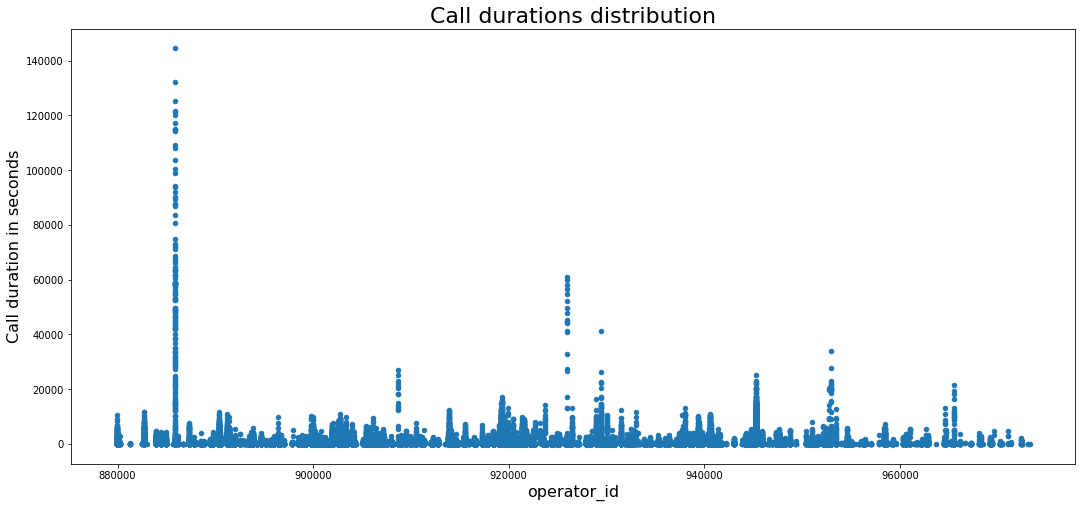

In [33]:
df_data.astype({'operator_id': 'int64'}).plot.scatter(x='operator_id',y='call_duration',figsize=(18,8))
plt.title('Call durations distribution',fontdict={'fontsize':22})
plt.xlabel('operator_id',fontdict={'fontsize':16})
plt.ylabel('Call duration in seconds',fontdict={'fontsize':16})
plt.show()

# a alook into distribution of call duration

easy to notice for an outliers<p>
a single call can't be 20,000 seconds for example (about 14 hours)

lets define an acceptable call duration<p>
I assume in the most difficult cases of operator a call shouldn't be more than 1.5 hours<p>
__we that been said we will need to remove call durations with more than 5400 seconds__

In [34]:
df_data[df_data['call_duration'] > 5400]['call_duration'].value_counts().sum()
# we will removed this amount of rows
# it stands with a correct number of rows compared to dataset and not exceeding high percent of all dataset

1422

In [35]:
# lets slice data :
df_data = df_data[df_data['call_duration'] <= 5400]
df_data.sample(4)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
21678,167035,2019-11-11,in,False,923528,False,3,123,212
47963,168187,2019-10-30,out,False,937988,True,7,0,235
37605,167630,2019-10-02,in,False,920666,False,2,521,539
5620,166520,2019-11-22,out,False,910902,False,2,632,655


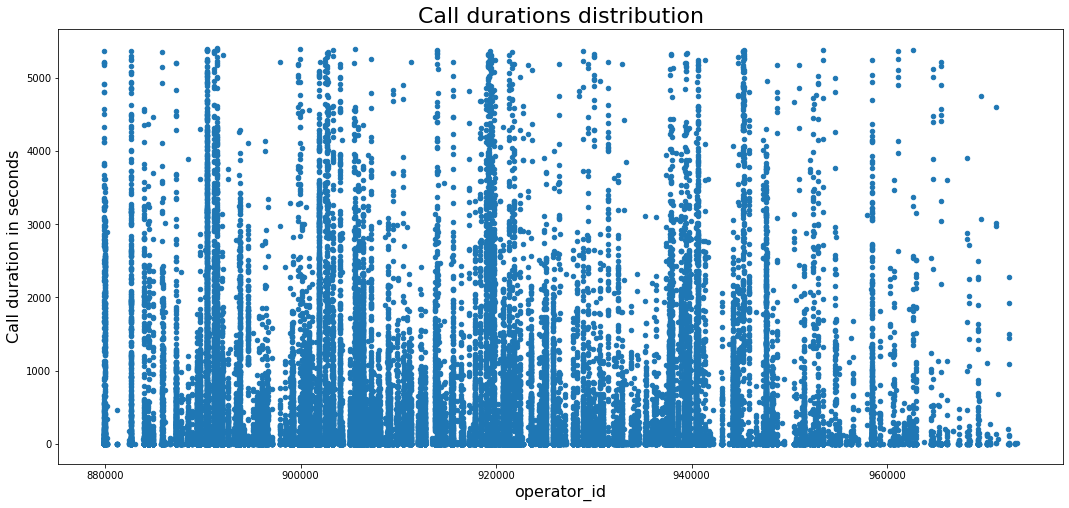

In [36]:
df_data.astype({'operator_id': 'int64'}).plot.scatter(x='operator_id',y='call_duration',figsize=(18,8))
plt.title('Call durations distribution',fontdict={'fontsize':22})
plt.xlabel('operator_id',fontdict={'fontsize':16})
plt.ylabel('Call duration in seconds',fontdict={'fontsize':16})
plt.show()

# a alook into distribution now

In [37]:
# number of call that user was waiting more than 30 minutes (1800 seconds):
df_data[df_data['total_call_duration'] > 7200]['total_call_duration'].value_counts().sum()

146

lets consider these as outliers as well<p>
a user would probably wont wait more than half an hour <p>
lets assume that in this soecific place there is a law that inforce companys not wait that long :)

In [38]:
# will remove outliers:
df_data = df_data[df_data['total_call_duration'] <= 7200]

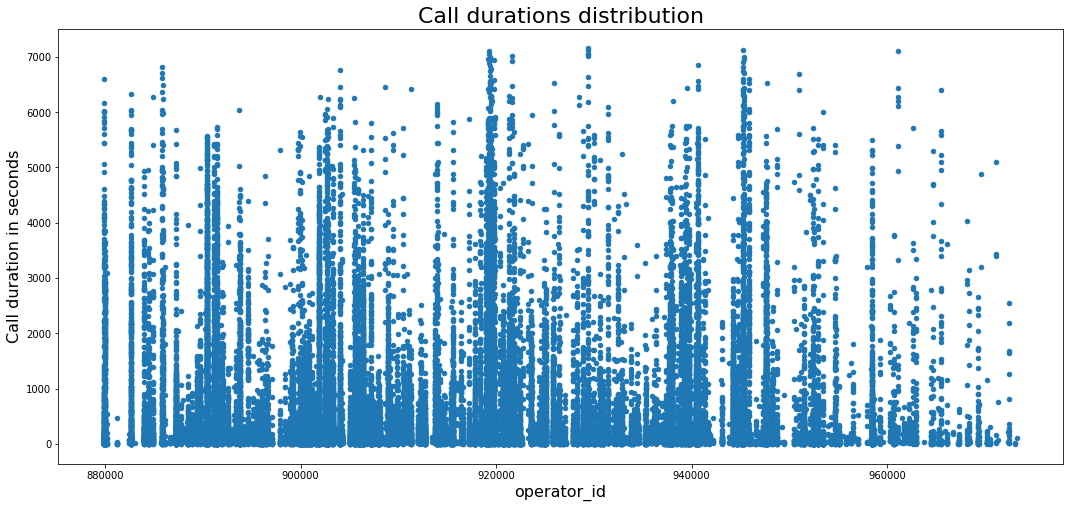

In [39]:
df_data.astype({'operator_id': 'int64'}).plot.scatter(x='operator_id',y='total_call_duration',figsize=(18,8))
plt.title('Call durations distribution',fontdict={'fontsize':22})
plt.xlabel('operator_id',fontdict={'fontsize':16})
plt.ylabel('Call duration in seconds',fontdict={'fontsize':16})
plt.show()

# a alook into distribution with total_call_duration - look ok

_'calls_count'_ columns have his outliers as well

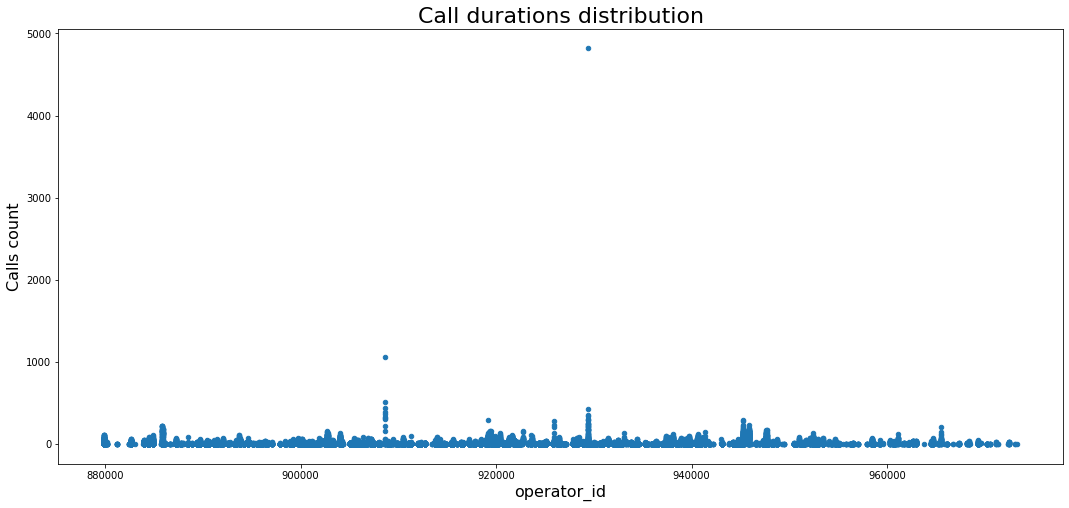

In [40]:
df_data.astype({'operator_id': 'int64'}).plot.scatter(x='operator_id',y='calls_count',figsize=(18,8))
plt.title('Call durations distribution',fontdict={'fontsize':22})
plt.xlabel('operator_id',fontdict={'fontsize':16})
plt.ylabel('Calls count',fontdict={'fontsize':16})
plt.show()

# a alook into distribution with total_call_duration - look ok

looking in stats and graph above we can say in confidance that more than 60 calls is an outlier <p>
as well this figure of 60 allow us to drop a legit amount of rows

In [41]:
'total rows dropped: {}'.format(df_data.query('(calls_count  > 60)').shape[0])

'total rows dropped: 1220'

In [42]:
df_data = df_data.query('~(calls_count  > 60)')

Conclusions:
- with our preprocessing we able to find that clients data has more "clean" data with no necessary adjustments to be done
- on the contarary in our dataset we had to make more adjustments where we remove a big set of dupplicates. removed more rows with NaN values (internal col) and replaced NaNs at operator_id column with the id of the rows above
- outliers removed with call ongoing more than 1.5 hours long
- outliers removed with calls waiting more than 30 minutes for operator to answer
- outlier number of calls count dropped as well when I decide to go with more than 60 calls as an outlier since it allow us to remove standard number of rows without damage our data and also remain with an ouliers that might give as some information further in the analysis

[Back to ToC](#content1)

# Step 3: Exploratory Data Analysis (EDA): <a class="anchor" id="step3"></a>


In [43]:
# lets merge tables into 1 df
df_merged = pd.merge(df_data,df_clients,on='user_id')
df_merged.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01


In [44]:
check = df_merged[df_merged['date']<df_merged['date_start']]

In [45]:
# lets look at the differences with dates:
(check['date'] - check['date_start']).value_counts()

-1 days    103
dtype: int64

with our check we able to find that it is only 1 day difference between the user call an date_start.<p>
this may happen of a delay update in the system. so lets assume -1 days differences is like 0 days difference

In [46]:
# lets fix the original dataset
df_merged['date_start'] = df_merged.apply(lambda x: x['date_start'] if x['date'] >= x['date_start'] else x['date'], axis=1)
df_merged.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01


In [47]:
# just to be sure:
df_merged[df_merged['date']<df_merged['date_start']]
# look ok

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


distributions of 'internal' , 'is_missed_call' , 'direction' columns

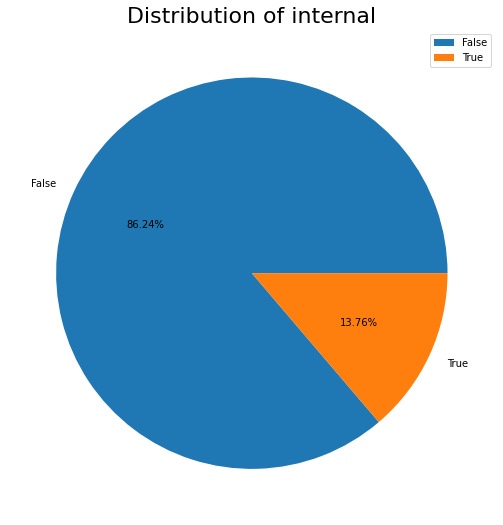

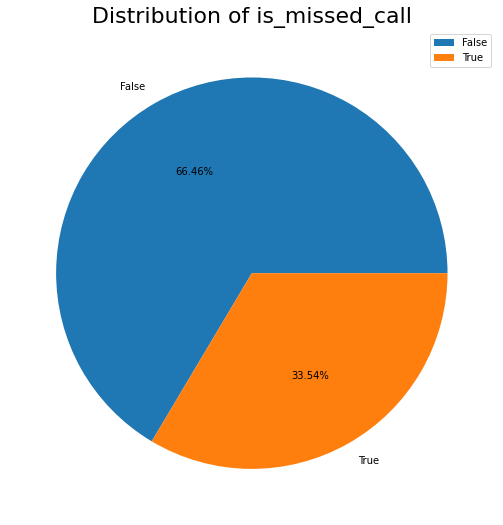

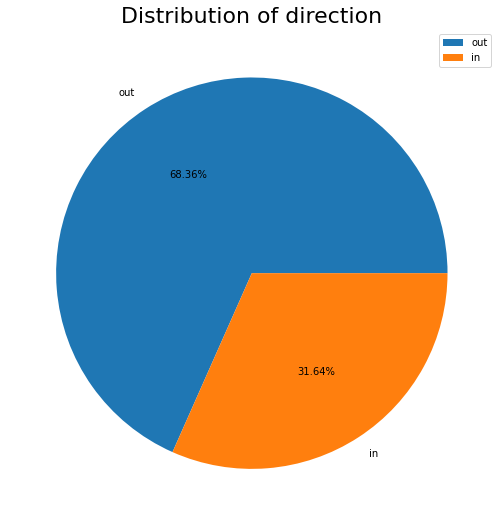

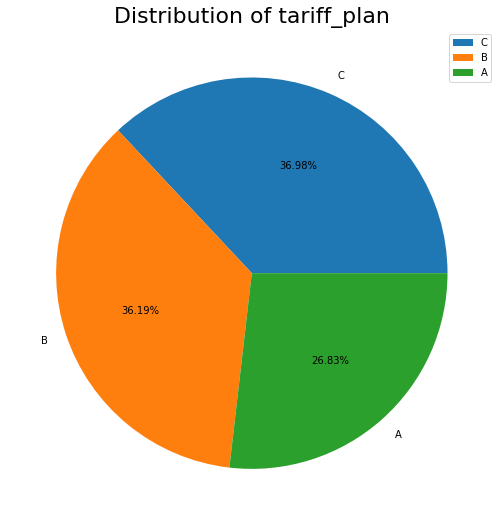

In [48]:
cols = ['internal','is_missed_call','direction','tariff_plan']
for col in cols:
  graph = df_merged[col].value_counts(normalize=True).reset_index()
  graph.columns = [col,'proportion']
  graph['proportion'] = graph['proportion'] * 100
  # plot:
  graph.set_index(col).plot.pie(y='proportion',autopct="%.2f%%",figsize=(17,9))
  plt.title('Distribution of '+col,fontdict={'fontsize':22})
  pylab.ylabel('')
  pylab.xlabel('')
  plt.show()

- almost 90% calls are internal
- about every 2nd call is a missed call
- 40% of call are incoming calls
- all 3 tariff groups are divided about the same except grouo A with only 26%

- ## Slice data :
- ### top 50 number of daily  missed calls for an operator
  

In [49]:
# first see how many operators are they:
df_merged['operator_id'].nunique()

1092

In [50]:
# make query:
operator_missed = df_merged.query('is_missed_call == True').groupby('operator_id')['is_missed_call'].count().reset_index().sort_values(by='is_missed_call',ascending=False)
operator_missed.head(10)

,operator_id,is_missed_call
63,891410,118
64,891414,113
165,901880,110
89,893804,106
166,901884,103
204,905538,91
27,887276,89
4,880026,87
1,879898,86
65,891416,83


In [51]:
# lets have mean as an indicator to number of missed calls (whole group):
operator_missed['is_missed_call'].mean()

14.85351787773933

In [52]:
# good to have the median as well
operator_missed['is_missed_call'].median()

7.0

In [53]:
# have top 50:
operator_missed = operator_missed[:50]

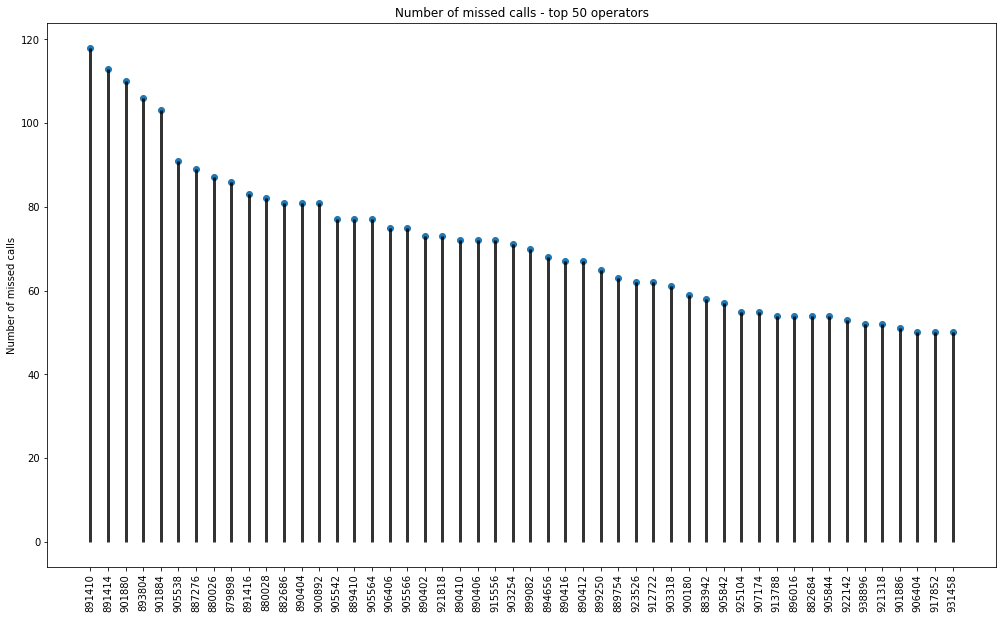

In [54]:
# plot:
fig, ax = plt.subplots(figsize=(17,10))
ax.vlines(x=operator_missed['operator_id'],ymin=0,ymax=operator_missed['is_missed_call'],alpha=0.8,linewidth = 3)
ax.scatter(x=operator_missed['operator_id'],y=operator_missed['is_missed_call'])
ax.set_title('Number of missed calls - top 50 operators')
ax.set_ylabel('Number of missed calls')
ax.set_xticks(operator_missed['operator_id'])
ax.set_xticklabels(operator_missed['operator_id'],rotation= 90)
plt.show()

- within number of missed calls we will probably accept number of no more than 20 calls unanswered
- looking at top 50 operators with most missed calls we able to see that they all over the mean figure
- we initialy looked at the meadian as well so skewness was noted when it is easy to see where is the impact on the mean value comes from only by looking on the top 50 
- lots of operators are with small number of missed calls while the ones with highest amount of missed calls make the balance to there side making skew results

- ### Most pending time calls 

In [55]:
df_merged.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01


In [56]:
# lets add new col with seconds waiting:
df_merged['pending_time'] = df_merged['total_call_duration'] - df_merged['call_duration']

In [57]:
# lets have data from all the 3 relevant columns
call_dur = df_merged.groupby('date').mean()['call_duration'].sort_values(ascending=False).reset_index()
total_dur = df_merged.groupby('date').mean()['total_call_duration'].sort_values(ascending=False).reset_index()
pending_dur = df_merged.groupby('date').mean()['pending_time'].sort_values(ascending=False).reset_index()

In [58]:
total = pd.concat([call_dur,total_dur,pending_dur]).fillna(0).reset_index().drop(columns='index').groupby('date').sum().reset_index()
total

,date,call_duration,total_call_duration,pending_time
0,2019-08-01,27.166667,81.166667,54.000000
1,2019-08-02,160.333333,237.333333,77.000000
2,2019-08-03,38.000000,49.666667,11.666667
3,2019-08-04,175.250000,274.500000,99.250000
4,2019-08-05,463.357143,555.285714,91.928571
...,...,...,...,...
113,2019-11-23,453.839378,640.787565,186.948187
114,2019-11-24,562.431522,710.134783,147.703261
115,2019-11-25,588.980070,749.038687,160.058617
116,2019-11-26,569.658378,723.658378,154.000000


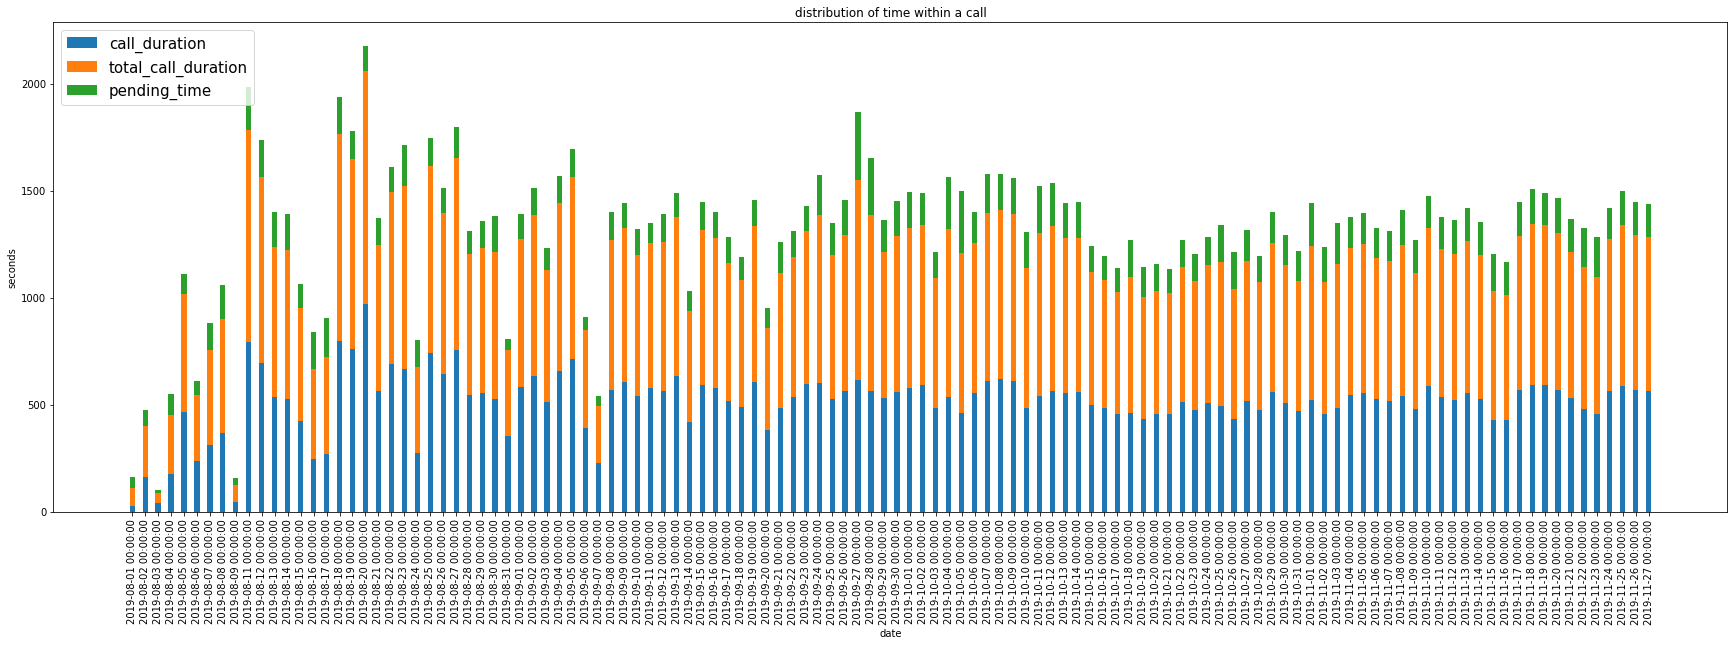

In [59]:
# define variable
date = total.iloc[:,0]
call_duration = total.iloc[:,1]
total_call_duration = total.iloc[:,2]
pending_time = total.iloc[:,3]
x = np.arange(len(total))

# plotting stacked bars:
plt.figure(figsize=(30,9),facecolor='white')
graph_call_duration = plt.bar(x=x, height=call_duration,width=0.4,label='call_duration')
graph_total_call_duration = plt.bar(x=x, height=total_call_duration,width=0.4,bottom=call_duration,label='total_call_duration')
graph_pending_time = plt.bar(x=x, height=pending_time,width=0.4,bottom=total_call_duration+call_duration,label='pending_time')
# labels + legend
plt.xlabel('date')
plt.ylabel('seconds')
plt.xticks(x,date,rotation= 90)
plt.title('distribution of time within a call')
plt.legend(loc='upper left',prop={'size':'15'})
plt.show()


- most of the time periods total seconds distribution is aoubt the same where we do have few days samples as an outliers (2019-08-10 with a very low measures)
- Ideal assumption for our operators would probably lead us to a graph where pending+call=total but it is not the case since we have a lot of missed calls
- proportions remain the same about the whole period where total_call is the most dominant in terms of time

[Back to ToC](#content1)

# Step 4: Determine ineffective operators <a class="anchor" id="step4"></a>


**Definition** - Operators with long pending_time (Over 60 sconds in average) and long call_duration (over 300 seconds in average) I will consider as an ineffective operators.<p>
With effevtive operator we will take only the operators that did not missed their call

In [60]:
# definition

missed = df_merged.query('direction == "in"').groupby('operator_id').agg({'is_missed_call':'sum','pending_time':'mean'}).reset_index()\
.rename(columns={'is_missed_call':'missed_calls'})

out_calls = df_merged.query('direction == "out"').groupby('operator_id').agg({'calls_count':'count'}).reset_index()\
.rename(columns={'calls_count':'out_calls'})

In [61]:
out_calls[out_calls['out_calls'] == 0]
# no zero here - here we have all the operators that can make out calls

,operator_id,out_calls


In [62]:
# lets merge tables into 1 df
general = missed.set_index('operator_id').join(out_calls.set_index('operator_id')).reset_index().fillna(0)

In [63]:
general.describe()
# a look into stats

,missed_calls,pending_time,out_calls
count,753.000000,753.000000,753.000000
mean,0.544489,53.596529,27.037185
std,1.631945,80.753917,39.228514
min,0.000000,1.000000,0.000000
25%,0.000000,17.500000,0.000000
50%,0.000000,30.800000,9.000000
75%,0.000000,57.125000,40.000000
max,16.000000,991.322581,226.000000


In [64]:
# having stats above we can segregate groups as below with the mean figures from general table above
ineffective = general.query('((pending_time > 30) or (missed_calls > 0) or (1 <= out_calls < 9))')
effective = general.query('((pending_time <= 30) and (missed_calls == 0) and (out_calls >= 9))')

In [65]:
ineffective.describe()

,missed_calls,pending_time,out_calls
count,516.000000,516.000000,516.000000
mean,0.794574,70.301895,29.405039
std,1.920874,92.784662,42.163306
min,0.000000,1.000000,0.000000
25%,0.000000,30.193750,1.000000
50%,0.000000,45.078947,8.000000
75%,1.000000,75.006944,42.000000
max,16.000000,991.322581,226.000000


In [66]:
effective.describe()

,missed_calls,pending_time,out_calls
count,131.0,131.000000,131.000000
mean,0.0,18.013329,39.587786
std,0.0,7.112321,32.896310
min,0.0,2.000000,9.000000
25%,0.0,13.166667,14.000000
50%,0.0,18.250000,29.000000
75%,0.0,23.645833,55.500000
max,0.0,30.000000,164.000000


[Back to ToC](#content1)

# Step 5: Test hypotheses <a class="anchor" id="step5"></a>

- define alpha as 0.05
- H0 & H1 statements for each test
- correlation check

In [67]:
ineffective.corr()

,missed_calls,pending_time,out_calls
missed_calls,1.00000,0.20667,0.21364
pending_time,0.20667,1.00000,0.17217
out_calls,0.21364,0.17217,1.00000


In [68]:
effective.corr()

,missed_calls,pending_time,out_calls
missed_calls,NaN,NaN,NaN
pending_time,NaN,1.000000,0.048792
out_calls,NaN,0.048792,1.000000


- Number are not correlated highly with each other - no sign of multicollinearity
- missed_calls with only zero 

In [69]:
effective['missed_calls'].isna().sum()

0

In [70]:
alpha = 0.01

__if p-value is less than alpha we reject hypothesis__

In [71]:
cols = ['missed_calls','pending_time','out_calls']
for col in cols:
  result = st.ttest_ind(ineffective[col], effective[col])
  print("H0: μ0 = μ1 \ mean " +col+" of ineffective operators is equal to mean of effective operators")
  print("H1: μ0 ≠ μ1 \ mean "+col+" of ineffective operators is not equal to mean of effective operators")
  
  if result.pvalue < alpha:
      print('Reject H0 hypothesis')
  else:
      print('Can\'t reject H0 hypothesis')

  print('p-value: {}'.format(result.pvalue))
  print()

H0: μ0 = μ1 \ mean missed_calls of ineffective operators is equal to mean of effective operators
H1: μ0 ≠ μ1 \ mean missed_calls of ineffective operators is not equal to mean of effective operators
Reject H0 hypothesis
p-value: 2.737278452563595e-06

H0: μ0 = μ1 \ mean pending_time of ineffective operators is equal to mean of effective operators
H1: μ0 ≠ μ1 \ mean pending_time of ineffective operators is not equal to mean of effective operators
Reject H0 hypothesis
p-value: 2.3124708265796615e-10

H0: μ0 = μ1 \ mean out_calls of ineffective operators is equal to mean of effective operators
H1: μ0 ≠ μ1 \ mean out_calls of ineffective operators is not equal to mean of effective operators
Can't reject H0 hypothesis
p-value: 0.010333117266722393



- 2 out 3 test we can't reject the h0 meaning which leads us to a conclusion that when using a sgnificance level it is hard to say that there is a differences between the effective and ineffective groups when testing missed_calls  & pending_time 
- When looking at number of out_calls we were able to reject h0 and probably indicate that μ0 ≠ μ1

[Back to Toc](#content1)

# Step 6: Conclusions <a class="anchor" id="step6"></a>

- when first looking at the data and preprocessing it we found a solid number of outliers that skew the data and may impact badly to our conclusion. Decided to remove the ones that was match our guidlines an explanations for doing that.some of them probably was a typo records that should have been reverted back to the BI team to further investigate the figures we got
- also raw data was filled with a lot of duplicates that was removed in the same point.
- Operators that have empty values ​​we assumed that it was a typo also and was replaced with the above value assuming the records of the operator have a big change to come each other
- impact of 0 was noticed within call_duration column that was also referred as unanswered call
- operator considered ineffective if they have a large number of missed incoming calls (internal and external), long waiting time for incoming calls and small outgoing calls. here I created 2 data frames and than joined them togther. next I definced ineffective & effevtive operators using mean as standard values
- hypothesis check - we couldn't rejecet 2 out of 3 hypothesis which means there are not difference between the 2 groups in terms of missed_calls  & pending_time  (waiting) time.
- H0 rejected only with number of out_calls - there are differences between effective and ineffective groups by their number of missed calls. alpha = 0.01

[Back to ToC](#content1)

# Step 7: Resources<p><a class="anchor" id="step7"></a>

https://www.isixsigma.com/tools-templates/hypothesis-testing/making-sense-two-sample-t-test/<p> Two sample test  helps to answer questions like whether the average success rate is higher after implementing a new method than the one before 

https://www.quora.com/What-is-the-difference-between-A-B-testing-and-a-t-test <p>here we have the differences between a/b tests and t-test 

https://www.jmp.com/en_ch/statistics-knowledge-portal/t-test/t-distribution.html <p>explainations about assumptions while using t-tests. gave me a clearer understanding using ttest

https://www.statisticshowto.com/probability-and-statistics/non-normal-distributions/ <p>some clarifications to cases where the data is not normally distributed. Eventhough this is an advanced techniques it helped me to be aware of cases like this and how should we deal with the in the future

https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/t-score-vs-z-score/

https://www.youtube.com/watch?v=I_hXQ1vatV0&feature=emb_title <p>
differences between z-score and t-score. helped to understand how should we run hypothesis tests on our case. Eventhough the variation is known between our groups of test it is ok to use t-test as we did here and explained in the video

https://en.wikipedia.org/wiki/Multiple_comparisons_problem <p>
Multi testing - to avoid multiple comparisons problem

In [72]:
# Generate new proccesed data csv file  
from google.colab import files
df_merged.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 8: Visualization using Tableu<p><a class="anchor" id="step8"></a>

Simple Tableu visualization [here](https://public.tableau.com/profile/art7498#!/vizhome/Telecom_16105685451880/Dashboard1?publish=yes) <a class="anchor" id="step8"></a>


[Back to ToC](#content1)